# Denoising Diffusion Probabilistic Models (DDPM)

This notebook are my personal notes on the implementation of DDPM based on [Ho et al. (2020)](https://arxiv.org/abs/2006.11239#) and [Brian Pulfer Tutorial](https://medium.com/mlearning-ai/enerating-images-with-ddpms-a-pytorch-implementation-cef5a2ba8cb1). The idea is to first apply a basic DDPM model to the MNIST data, then trying it out on the pokemon sprites dataset.

### Basic Idea

The basic idea is simple, given a set of images, we perturb each images through a Markov-Chain by adding a little bit of Gaussian Noise every timestep $t$ until Gaussian Noise is all that´s left. This process is called "forward diffusion" and follows the concept of non-equilibrium thermodynamics where the entropy is increased iteratively by adding noise. Now to revert this process, we learn a ML model (a DL model) to reverse this process to obtain high quality images back from noise iteratively (backward or reverse process). This way, a ML model learns the important/desired features from the dataset and learns to reconstruct these features from plain (Gaussian) noise.

### The math behind it

TBD: when I feel like doing LaTeX

$\mathcal{N}(x_t;\sqrt{1 - \beta_{t}x_{t-1}}, \beta_{t}I)$ is read as "Gaussian $\mathcal{N}$ PDF parametrized by $\mu=\sqrt{1 - \beta_{t}x_{t-1}}$, $\sigma = \beta{t}I$ evaluated at image $x$ at timestep $t$. A diagonal Covariance Matrix $\sigma$ indicates independency between all pixels in $x$.

## DDPM Implementation

In [1]:
no_train = False
batch_size = 128
n_epochs = 20
lr = 0.001
store_path = "ddpm_mnist.pt"

### Some Preprocessing and Preparations

In [37]:
import torch
import matplotlib.pyplot as plt

def show_images(images, title=""):
    """
    Convenience Method for displaying several images in a grid
    """

    # Convert to numpy from tensor
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Decide size of grid
    fig = plt.figure(figsize=(8,8))
    rows = int(len(images) ** (1/2))
    cols = round(len(images) / rows)

    # construct subplots
    i = 0
    for _ in range(rows):
        for _ in range(cols):
            ax = fig.add_subplot(rows, cols, i + 1)
            ax.axis('off')
            if i < len(images):
                plt.imshow(images[i][0], cmap="gray")
                i += 1
    fig.suptitle(title)

    plt.axis('off')
    plt.show()

In [38]:
from torchvision.datasets import MNIST
from torchvision import transforms
import os

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
# Init DataLoader from MNIST Dataset
mnist_ds = MNIST(PATH_DATASETS, train=True, download=True, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Lambda(lambda x: (x - 0.5) * 2),  #scale images to [-1:1]
                           ]))
mnist_loader = torch.utils.data.DataLoader(mnist_ds, batch_size=batch_size, shuffle=True)

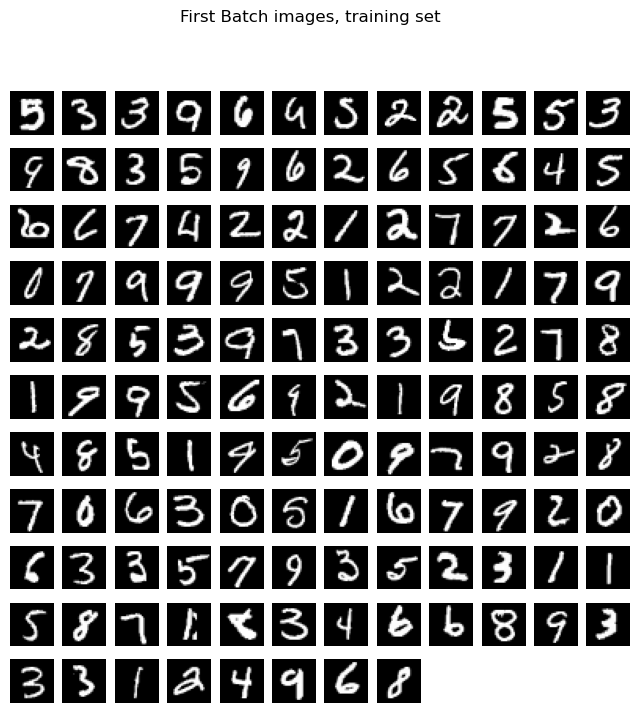

Using Device: cuda, 	NVIDIA GeForce RTX 3070 Ti


In [42]:
# show first images
for batch in mnist_loader:
    show_images(batch[0], "First Batch images, training set")
    break

# show device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}, \t" +  f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU")

### The DDPM Model